In [2]:
import cv2
import numpy as np
import imutils
import glob
import matplotlib.pyplot as plt
import os

Once the camera system has been callibrated, we will compute the depth based on triangulation. As seen in the slides.

In [3]:
def sum_abs_diff(image1, image2):
    image1 = image1.astype('int32')
    image2 = image2.astype('int32')
    sad = 0
    
    if image1.shape == image2.shape:
        diff = image1 - image2
        sad = np.sum(np.absolute(diff))
    else:
        sad = -1
    return sad

In [4]:
def scan_line(span, template, search_col_min, search_col_max):
    min_place = -1
    min_value = float('inf')
    
    for i in range(search_col_min, search_col_max):
        diff = sum_abs_diff(span[:, i:i + span.shape[0]], template)
        if diff < min_value:
            min_value = diff
            min_place = i
    return (min_place, min_value)

The depth function implements the computation, based on the knowledge of the disparity of the 2 pairs of pixels in the rectified image planes. 

The **baseline**  and the **focal lenght** are parameters of the function which condition the output.

Based on the assumption that the images are undistorted, we assume the rectified stereo vision case in which both image planes are horizontal and parallel. Therefore the epipolar lines are parallel and this creates a powerful set of constrains to find the corresponding point on the right image.

The point is recognised by the disparity of a sliding window through the epipolar line. The lowest Sum of Absolute Difference will determine the right point on the left.

Once the point has been found on the right image, disparity can be computed as the difference of the horizontal distances between the point in each image to the center of the image.

Depth can be computed from the disparity simply applying the formula:


In [5]:
def Depth(leftGrayImg, rightGrayImg, positionOnLeft, halfWindow, baseline = 120, focalLength = 700):
    """
    The function takes 6 arguments:
    - The 2 images that are to be used to compute the triangulation,
    - The position of the pixel in the left image,
    - The size of the window to prompt in the template which is also the size of the Sliding window.
    """
        
    template = leftGrayImg[positionOnLeft[0]-halfWindow:positionOnLeft[0]+halfWindow,\
                           positionOnLeft[1]-halfWindow:positionOnLeft[1]+halfWindow]
    plt.figure()
    plt.imshow(template)
    
    span = rightGrayImg[positionOnLeft[0]-halfWindow:positionOnLeft[0]+halfWindow, :]
    plt.figure()
    plt.imshow(span)
    min_place, min_value = scan_line(span, template, positionOnLeft[1]-250, positionOnLeft[1]-50-halfWindow)
    
    disparity = positionOnLeft[1]-min_place
    print("Disparity: ", disparity, "mm")
    
    depth = focalLength*baseline/(disparity)
    #print(f"Depth of pixel [{positionOnLeft[0]},{positionOnLeft[1]}] in mm: {depth}")
    return depth

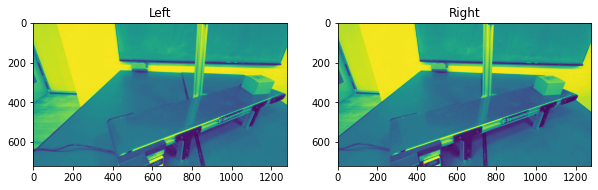

Disparity:  101 mm
Depth:  831.6831683168317 mm


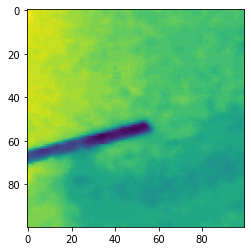

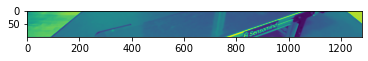

In [6]:
#Figure parameters
width = 10
height = 10
fig = plt.figure(figsize=(10, 8))
columns = 2
rows = 1

#EXAMPLE OF DEPTH ESTIMATION
left = cv2.imread('./../../Data/Stereo_conveyor_without_occlusions_undistorted/left/1585434283_489372015_Left.png')
imgleft=cv2.imread('./../../Data/Stereo_conveyor_without_occlusions_undistorted/left/1585434283_489372015_Left.png',0)
left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)

fig.add_subplot(1, 2, 1)
plt.imshow(left)
plt.title("Left")

right = cv2.imread('./../../Data/Stereo_conveyor_without_occlusions_undistorted/right/1585434283_489372015_Right.png')
imgright=cv2.imread('./../../Data/Stereo_conveyor_without_occlusions_undistorted/right/1585434283_489372015_Right.png',0)
right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

fig.add_subplot(1, 2, 2)
plt.imshow(right)
plt.title("Right")
plt.show()

depth = Depth(left, right, positionOnLeft=(450,500), halfWindow=50)

print("Depth: ", depth, "mm")

For calculating the depth from disparity, OpenCV has the function reprojectImageTo3d.

You need the disparity-to-depth matrix (Q) from stereo rectification (or you can create it as given in the link). You can learn more about the Q matrix here.

After getting the Q matrix, you can simply reproject the disparity map to 3D

depth = cv2.reprojectImageTo3D(disparity, Q)

The above is a test to show how the fucntion computes the Depth.
Now we will craete depth maps based on the recursive use of the function.

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [ ]:
#TEST EPILOLAR LINES FOR RECTIFIED IMAGES

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_rectified, None)
kp2, des2 = sift.detectAndCompute(img2_rectified, None)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 300

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    

# Implement findFundamentalMat here:
F, mask = cv2.findFundamentalMat(pts1,pts2)


# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1_rectified, img2_rectified, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2_rectified, img1_rectified, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

In [1]:
min_disp = 1*16 # 7
num_disp = 4*16 # 3*16
block_size = 11 # NEEDS TO BE ODD. LARGER= SMOOTHER AND LESS ACCURATE

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)

stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200) # 200
stereo.setUniquenessRatio(3) # 3
stereo.setSpeckleRange(3) # 3
stereo.setSpeckleWindowSize(100) # 3
disparity = stereo.compute(imgleft, imgright)

min = disparity.min()
max = disparity.max()
disparity = np.uint8(6400 * (disparity - min) / (max - min))

cv2.imshow('disparittet', np.hstack((imgleft, imgright, disparity)))
plt.imshow(disparity)

NameError: name 'cv2' is not defined

BUT HOW CAN WE USE DEPTH MAPS? 


In [ ]:
def BackgroundRemoval(leftImages):
    # Define kalman
    kalman = cv2.KalmanFilter(6,3)
    kalman.measurementMatrix = np.array([[1,0,0,0,0,0],
                                         [0,0,1,0,0,0],
                                         [0,0,0,0,1,0]], np.float32)
    kalman.transitionMatrix = np.array([[1,1,0,0,0,0],
                                        [0,1,0,0,0,0],
                                        [0,0,1,1,0,0],
                                        [0,0,0,1,0,0],
                                        [0,0,0,0,1,1],
                                        [0,0,0,0,0,1]], np.float32)
    kalman.processNoiseCov = np.eye(6, dtype=np.float32) * 0.03
    kalman.measurementNoiseCov = np.eye(3, dtype=np.float32) * 0.06
    measurement = np.array((3,1), np.float32)
    prediction = np.zeros((6,1), np.float32)
    
    # Background removal
    fgbg = cv2.createBackgroundSubtractorKNN(history=1000, dist2Threshold=1000, detectShadows=False)
    
    # Define parameters to check it is new object?
    thresholdCenter = 10
    prevCenter = (0, 0)
    prevRadius = 0
    thresholdRadius = 5
    
    for leftName in leftImages:
        rightName = leftName.replace('left','right').replace('Left','Right')
        
        # Read left frame to get object detection running
        originalFrame = cv2.imread(leftName)
        leftGray = cv2.cvtColor(originalFrame, cv2.COLOR_BGR2GRAY)
                
        # Make a prediction
        prediction = kalman.predict()
        
        # Get the mask of the object
        mask = fgbg.apply(originalFrame)
        
        # Erode it and dilate it to avoid small points
        kernel = np.ones((5,5), np.uint8) 
        mask = cv2.erode(mask, kernel, iterations=1) 
        mask = cv2.dilate(mask, kernel, iterations=1) 

        # Bitwise-AND mask and original image
        frame = cv2.bitwise_and(originalFrame, originalFrame, mask=mask)
        
        # Make a crop to focus in the moving thing
        cropTop = 200
        cropBottom = 600
        cropLeft = 300
        cropRight = 1150
        cropped = mask[cropTop:cropBottom, cropLeft:cropRight]
        
        # Find contours
        cnts, _ = cv2.findContours(cropped.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Only proceed if at least one contour was found
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            if M["m00"] == 0.0:
                continue
            center = (int(M["m10"] / M["m00"])+cropLeft, int(M["m01"] / M["m00"])+cropTop)
            
            # only proceed if the radius meets a minimum size
            if radius > 20 and radius < 200 and radius + thresholdRadius >= prevRadius:
                # draw the circle and centroid on the frame,
                # then update the list of tracked points
                cv2.circle(originalFrame, (int(x)+cropLeft, int(y)+cropTop), int(radius),
                    (0, 255, 255), 2)
                cv2.circle(originalFrame, center, 5, (0, 0, 255), -1)
                
                right = cv2.imread(rightName)
                rightGray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
                
                depth = Depth(leftGray, rightGray, center, 50)
                print(depth)
                    
                cv2.putText(originalFrame, f"Depth: {depth:.2f} mm", (0,200), cv2.FONT_ITALIC, 1, (0,0,0))
                
                # Correct kalman 
                kalman.correct(np.array([np.float32(center[0]), np.float32(center[1]), np.float32(depth)], np.float32))
                
                prevRadius = radius
                text = "Object found at:"
                colour = (0, 255, 0)
                cv2.putText(originalFrame,"({}, {})".format(center[0], center[1]), (0, 100), cv2.FONT_ITALIC, 1, colour)

                if (center[0] > prevCenter[0] + thresholdCenter) and (center[1] < prevCenter[1] - thresholdCenter):
                    kalman = cv2.KalmanFilter(6,3)
                    kalman.measurementMatrix = np.array([[1,0,0,0,0,0],
                                         [0,0,1,0,0,0],
                                         [0,0,0,0,1,0]], np.float32)
                    kalman.transitionMatrix = np.array([[1,1,0,0,0,0],
                                        [0,1,0,0,0,0],
                                        [0,0,1,1,0,0],
                                        [0,0,0,1,0,0],
                                        [0,0,0,0,1,1],
                                        [0,0,0,0,0,1]], np.float32)
                    kalman.processNoiseCov = np.eye(6, dtype=np.float32) * 0.1#0.03
                    kalman.measurementNoiseCov = np.eye(3, dtype=np.float32) * 0.02
                    # New object
                    print("New object!")
                    objectFound = False
                    prevRadius = 0
                prevCenter = center
            else:
                # Object not found
                text = "Object not found"
                objectFound = False
                colour = (0, 0, 255)
                
        else: 
            # Object not found
            text = "Object not found"
            objectFound = False
            colour = (0, 0, 255)
            prevRadius = 0
            
        prediction = kalman.predict()
#         originalFrame = cv2.rectangle(originalFrame, (prediction[0]-(0.5*w), prediction[1]-(0.5*h)), 
#                                 (prediction[0]+(0.5*w), prediction[1]+(0.5*h)), (0,255,0),2)
        # cv2.circle(originalFrame, (prediction[0]+prediction[2], prediction[1]+prediction[3]), 5, (255, 0, 0), -1)
        cv2.putText(originalFrame,"({}, {}, {})".format(prediction[0], prediction[2], prediction[4]), 
                    (0, 150), cv2.FONT_ITALIC, 1, colour)
    
            
        cv2.putText(originalFrame, text, (0, 50), cv2.FONT_ITALIC, 1, colour)

        cv2.imshow('res', originalFrame)

        #press 'q' to kill
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    return 

leftImages = glob.glob('./../../Data/Stereo_conveyor_without_occlusions_undistorted/left/*.png')
assert leftImages

BackgroundRemoval(leftImages)